# The "You Are What You Eat" Customer Segmentation

**Author:** Ruthy Yao
***

## Project Overview

ABC Grocery Store has accumulated large amount of data from customers' day-to-day shopping. The wealth of the data could render the leadership team invaluable insights into their customers. 

This project provide a customer segmentation based on the relative weight of the customer's spend across the product categories. Applying the Kmeans Clustering algorithm, we grouped the customers into three segments. The leadership team can use this segmentatiion to optimize their campaign and promotional offering, improve the inventory planning and drive more sales. 

## Business Problem

ABC grocery store's transactions data shows that their customers have a fair bit of spread of spending across different product areas. The management team would like to know whether the difference is just due to the size of their households or is driven by their lifestyle. The management team asked the data analytics team to dig into the data to see if there is any distinct clusters of their customer base. If so, we can rely on these insights to customize our communication on product recommendation and promotions and also optimize our inventory.

## Data Understanding 

In [7]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# import the datasets
transactions = pd.read_excel('data/grocery_database.xlsx', sheet_name = 'transactions')
product_areas = pd.read_excel('data/grocery_database.xlsx', sheet_name = 'product_areas')

In [9]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38506 entries, 0 to 38505
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customer_id       38506 non-null  int64         
 1   transaction_date  38506 non-null  datetime64[ns]
 2   transaction_id    38506 non-null  int64         
 3   product_area_id   38506 non-null  int64         
 4   num_items         38506 non-null  int64         
 5   sales_cost        38506 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 1.8 MB


In [10]:
transactions.head()

,customer_id,transaction_date,transaction_id,product_area_id,num_items,sales_cost
0,1,2020-04-10,435657533999,3,7,19.16
1,1,2020-04-10,435657533999,2,5,7.71
2,1,2020-06-02,436189770685,4,4,26.97
3,1,2020-06-02,436189770685,1,2,38.52
4,1,2020-06-10,436265380298,4,4,22.13


In [11]:
product_areas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   product_area_id    5 non-null      int64  
 1   product_area_name  5 non-null      object 
 2   profit_margin      5 non-null      float64
dtypes: float64(1), int64(1), object(1)
memory usage: 252.0+ bytes


In [12]:
product_areas.head()

,product_area_id,product_area_name,profit_margin
0,1,Non-Food,0.25
1,2,Vegetables,0.18
2,3,Fruit,0.14
3,4,Dairy,0.19
4,5,Meat,0.11


There are over 38,500 pieces of transaction data in the `transaction` data table. Since we need to have a dataset that gives us the information on the spent by product area, I'll merge the two data tables using the `product_area_id` is the key.

In [14]:
# Merge on product area id
transactions =pd.merge(transactions,product_areas, how = 'left', on = 'product_area_id')

In [15]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38506 entries, 0 to 38505
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        38506 non-null  int64         
 1   transaction_date   38506 non-null  datetime64[ns]
 2   transaction_id     38506 non-null  int64         
 3   product_area_id    38506 non-null  int64         
 4   num_items          38506 non-null  int64         
 5   sales_cost         38506 non-null  float64       
 6   product_area_name  38506 non-null  object        
 7   profit_margin      38506 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 2.4+ MB


## Data Preperation and Cleaning

### Create the data set

#### Drop the non-food category

In [19]:
# explore what product areas we have in the dataset.
transactions['product_area_name'].unique()

array(['Fruit', 'Vegetables', 'Dairy', 'Non-Food', 'Meat'], dtype=object)

Since the task is focused on the food spending, I'll exclude the "Non Food" category from the dataset.

In [21]:
non_food_transac = transactions[transactions['product_area_name'] == 'Non-Food']
transactions.drop(non_food_transac.index, axis = 0, inplace = True)

In [22]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30722 entries, 0 to 38505
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        30722 non-null  int64         
 1   transaction_date   30722 non-null  datetime64[ns]
 2   transaction_id     30722 non-null  int64         
 3   product_area_id    30722 non-null  int64         
 4   num_items          30722 non-null  int64         
 5   sales_cost         30722 non-null  float64       
 6   product_area_name  30722 non-null  object        
 7   profit_margin      30722 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 2.1+ MB


#### Aggregate the data

In [24]:
# Pivot the "transactions" datatable by customer_id by product_area_name
transaction_summary_pivot = transactions.pivot_table(index = 'customer_id',
                                                     columns = 'product_area_name',
                                                     values = 'sales_cost',
                                                     aggfunc = 'sum',
                                                     fill_value = 0,  # fill the na value with zero
                                                     margins = True,  # display the Total
                                                     margins_name = 'Total').rename_axis(None, axis = 1)  # to avoid both customer_id and product_area_name as the index.

In [25]:
transaction_summary_pivot

,Dairy,Fruit,Meat,Vegetables,Total
customer_id,,,,,
1,367.74,276.00,543.38,167.12,1354.24
2,150.63,120.93,241.21,99.05,611.82
3,46.20,75.39,171.13,31.50,324.22
4,341.91,245.36,272.79,142.35,1002.41
5,694.71,815.32,1405.19,350.10,3265.32
...,...,...,...,...,...
867,129.84,176.73,180.49,88.83,575.89
868,225.59,358.89,343.26,189.24,1116.98
869,126.28,127.50,183.88,168.85,606.51


In [26]:
# Turn the sales $ into %
transaction_summary_pivot = transaction_summary_pivot.div(transaction_summary_pivot['Total'], axis = 0)

In [27]:
transaction_summary_pivot

,Dairy,Fruit,Meat,Vegetables,Total
customer_id,,,,,
1,0.271547,0.203804,0.401244,0.123405,1.0
2,0.246200,0.197656,0.394250,0.161894,1.0
3,0.142496,0.232527,0.527821,0.097156,1.0
4,0.341088,0.244770,0.272134,0.142008,1.0
5,0.212754,0.249691,0.430338,0.107218,1.0
...,...,...,...,...,...
867,0.225460,0.306882,0.313411,0.154248,1.0
868,0.201964,0.321304,0.307311,0.169421,1.0
869,0.208208,0.210219,0.303177,0.278396,1.0


In [28]:
# drop the 'Total' column
data_for_clustering = transaction_summary_pivot.drop(['Total'], axis = 1)

In [29]:
data_for_clustering

,Dairy,Fruit,Meat,Vegetables
customer_id,,,,
1,0.271547,0.203804,0.401244,0.123405
2,0.246200,0.197656,0.394250,0.161894
3,0.142496,0.232527,0.527821,0.097156
4,0.341088,0.244770,0.272134,0.142008
5,0.212754,0.249691,0.430338,0.107218
...,...,...,...,...
867,0.225460,0.306882,0.313411,0.154248
868,0.201964,0.321304,0.307311,0.169421
869,0.208208,0.210219,0.303177,0.278396


### Data Preprocessing

#### Check the missing value

In [32]:
data_for_clustering.isna().sum()

Dairy         0
Fruit         0
Meat          0
Vegetables    0
dtype: int64

There is no missing value in the dataset.

#### Normalise the data

In [35]:
scale_norm = MinMaxScaler()
data_for_clustering_scaled = pd.DataFrame(scale_norm.fit_transform(data_for_clustering), columns = data_for_clustering.columns)

In [36]:
data_for_clustering_scaled

,Dairy,Fruit,Meat,Vegetables
0,0.309044,0.250873,0.432358,0.164665
1,0.280196,0.243305,0.424823,0.216022
2,0.162172,0.286229,0.568751,0.129640
3,0.388187,0.301300,0.293237,0.189487
4,0.242132,0.307357,0.463709,0.143065
...,...,...,...,...
866,0.256592,0.377756,0.337714,0.205820
867,0.229852,0.395509,0.331142,0.226066
868,0.236958,0.258769,0.326687,0.371476
869,0.266506,0.375354,0.289257,0.256806


#### Find a good value for k using WCSS

At this point here, our data is ready to be fed into the k-means clustering algorithm.  Before that however, I want to understand what number of clusters I want the data split into.

In the world of unsupervised learning, there is no *right or wrong* value for this - it really depends on the data we are dealing with, as well as the unique scenario we're utilising the algorithm for.  From ABC Grocery's management team, having a very high number of clusters might not be appropriate as it would be too hard for the business to understand the nuance of each in a way where they can apply the right strategies.

Finding the "right" value for k, can feel more like art than science, but there are some data driven approaches that can help us!  

The approach I will utilise here is called "Elbow Curve Method" which measures the sum of the squared euclidean distances that data points lie from their closest centroid, also known as "Within Cluster Sum of Squares (WCSS)".  WCSS can help us understand the point where adding *more clusters* provides little extra benefit in terms of separating our data.

I will run the dataset for a range of k (from 1 to 10). For each k, calculate the total within-cluster sum of squares (WCSS).  Plot these points. As you can see, the value for k (in other words, as we increase the number or centroids or clusters) the WCSS value will always decrease.  However, these decreases will get smaller and smaller each time we add another centroid. I will choose the k value where the WCSS falls suddenly before but almost flat after the point(“Elbow”).

In [39]:
import warnings
warnings.filterwarnings("ignore")

In [40]:
k_values = list(range(1,10))
wcss_list = []

for k in k_values:
    kmeans = KMeans(n_clusters = k,random_state = 42)
    kmeans.fit(data_for_clustering_scaled)
    wcss_list.append(kmeans.inertia_)

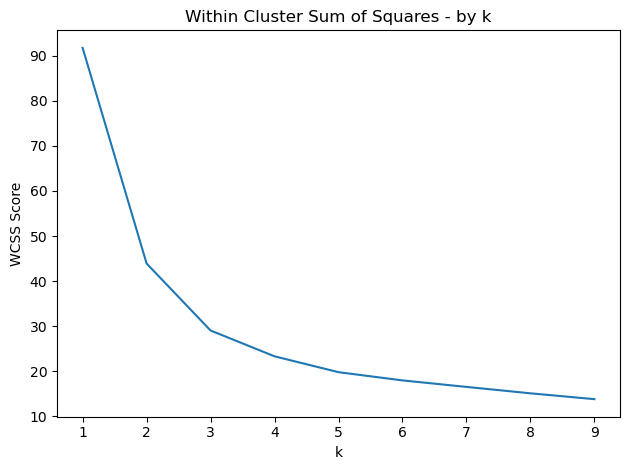

In [41]:
# Plot the k values
plt.plot(k_values, wcss_list)
plt.title('Within Cluster Sum of Squares - by k')
plt.xlabel('k')
plt.ylabel('WCSS Score')
plt.tight_layout()

plt.savefig("./images/WCSS_by_k.png", dpi =150)
plt.show()

It seams that before value of 3, WCSS falls suddenly, but after 3, the magnitude of the declining in WCSS score becomes marginal. I think 3 clusters would be good.

## Instantiate & fit model

In [44]:
kmeans = KMeans(n_clusters = 3,random_state = 42)
kmeans.fit(data_for_clustering_scaled)

KMeans(n_clusters=3, random_state=42)

In [45]:
# Add cluster labels to our data
data_for_clustering['cluster'] = kmeans.labels_

In [46]:
# check cluster sizes
data_for_clustering['cluster'].value_counts()

cluster
0    641
2    127
1    103
Name: count, dtype: int64

In [47]:
data_for_clustering

,Dairy,Fruit,Meat,Vegetables,cluster
customer_id,,,,,
1,0.271547,0.203804,0.401244,0.123405,0
2,0.246200,0.197656,0.394250,0.161894,0
3,0.142496,0.232527,0.527821,0.097156,0
4,0.341088,0.244770,0.272134,0.142008,0
5,0.212754,0.249691,0.430338,0.107218,0
...,...,...,...,...,...
867,0.225460,0.306882,0.313411,0.154248,0
868,0.201964,0.321304,0.307311,0.169421,0
869,0.208208,0.210219,0.303177,0.278396,0


### Cluster Summary

In [49]:
cluster_summary = data_for_clustering.groupby('cluster')[['Dairy','Fruit','Meat', 'Vegetables']].mean().reset_index()

In [50]:
cluster_summary

,cluster,Dairy,Fruit,Meat,Vegetables
0,0,0.220875,0.264605,0.376508,0.138011
1,1,0.002382,0.637796,0.003696,0.356126
2,2,0.363948,0.394152,0.029210,0.212690


### Visit Frequency and Shopping Basket Analysis

In [52]:
transactions_count = transactions.groupby(['customer_id'])['transaction_id'].count().reset_index()
transactions_count

,customer_id,transaction_id
0,1,38
1,2,34
2,3,12
3,4,33
4,5,84
...,...,...
865,866,49
866,867,33
867,868,46
868,869,41


In [53]:
sales = transactions.groupby(['customer_id'])['sales_cost'].sum().reset_index()
sales

,customer_id,sales_cost
0,1,1354.24
1,2,611.82
2,3,324.22
3,4,1002.41
4,5,3265.32
...,...,...
865,866,1005.04
866,867,575.89
867,868,1116.98
868,869,606.51


In [54]:
customers = pd.merge(data_for_clustering,transactions_count, on = 'customer_id', how = 'inner')
customers

,customer_id,Dairy,Fruit,Meat,Vegetables,cluster,transaction_id
0,1,0.271547,0.203804,0.401244,0.123405,0,38
1,2,0.246200,0.197656,0.394250,0.161894,0,34
2,3,0.142496,0.232527,0.527821,0.097156,0,12
3,4,0.341088,0.244770,0.272134,0.142008,0,33
4,5,0.212754,0.249691,0.430338,0.107218,0,84
...,...,...,...,...,...,...,...
865,866,0.206887,0.188798,0.457852,0.146462,0,49
866,867,0.225460,0.306882,0.313411,0.154248,0,33
867,868,0.201964,0.321304,0.307311,0.169421,0,46
868,869,0.208208,0.210219,0.303177,0.278396,0,41


In [55]:
customers = pd.merge(customers,sales, on = 'customer_id', how = 'inner')
customers

,customer_id,Dairy,Fruit,Meat,Vegetables,cluster,transaction_id,sales_cost
0,1,0.271547,0.203804,0.401244,0.123405,0,38,1354.24
1,2,0.246200,0.197656,0.394250,0.161894,0,34,611.82
2,3,0.142496,0.232527,0.527821,0.097156,0,12,324.22
3,4,0.341088,0.244770,0.272134,0.142008,0,33,1002.41
4,5,0.212754,0.249691,0.430338,0.107218,0,84,3265.32
...,...,...,...,...,...,...,...,...
865,866,0.206887,0.188798,0.457852,0.146462,0,49,1005.04
866,867,0.225460,0.306882,0.313411,0.154248,0,33,575.89
867,868,0.201964,0.321304,0.307311,0.169421,0,46,1116.98
868,869,0.208208,0.210219,0.303177,0.278396,0,41,606.51


In [56]:
clusters_transaction_sales = customers.groupby('cluster')[['transaction_id', 'sales_cost']].mean()
clusters_transaction_sales

,transaction_id,sales_cost
cluster,,
0,37.275000,991.092312
1,26.679612,701.097767
2,32.425197,756.584409


In [57]:
# Calculate the average shopping basket
clusters_transaction_sales['basket'] = clusters_transaction_sales['sales_cost']/clusters_transaction_sales['transaction_id']

In [58]:
# The data set has half-year's data, Let's caculate the monthly visits and the annual spend.
clusters_transaction_sales['transaction_id'] = clusters_transaction_sales['transaction_id'] / 6
clusters_transaction_sales['sales_cost'] = 2 *clusters_transaction_sales['sales_cost']

In [59]:
clusters_transaction_sales.rename(columns ={'transaction_id':'visit_count','sales_cost':'Annual_spend'} )

,visit_count,Annual_spend,basket
cluster,,,
0,6.212500,1982.184625,26.588660
1,4.446602,1402.195534,26.278410
2,5.404199,1513.168819,23.333225


Cluster 1 customers have the most frequent visits to the store hence the largest annual spends. Whereas Cluster 2 customer visit less than the other two groups. Cluster 3 customers' average spend per visit is smaller than the other two groups.

## Results & Insights

ABC Grocery's food customers is grouped into three clusters. 

* **Cluster 1**  - Customers have relatively balanced spend across the product areas with "Meat" the highest proportion of their shopping basket.
* **Cluster 2** - Customers barely spent any in "Diary" and "Meat" categories. Almost all of their shopping basket are "Fruit" and "Vegetables. This indicates that they might be "Vegetarian Shoppers".
* **Cluster 3** - Customers spend mainly on "Dairy", "Fruit" and "Vegetables", with only 3% on "Meat". Let's call them "Lacto-vegetarian".

Cluster 1 has the largest customer number. They also visit the store most frequently, making it the highest in the customer's annual spend. It's advisable that ABC Grocery monitor the performance of this cluster more closely to avoid any sudden slide from the sales target that may jeopardize the business performance overall. 

## Applications

Based upon these clusters, ABC Grocery will be able to target customers more accurately - promoting products & discounts to customers that are truly relevant to them - overall enabling a more customer focused communication strategy.

The visits and shopping basket analysis indicates that there is opportunity to increase the visit frequency from the cluster 2 "Vegetarian Shoppers". For example, ABC Grocery could send more seasonal promotions to attract more store visits. There is also opportunity to expand the shopping basket in cluster 3 "Lacto- vegetarian" shoppers. For instance, ABC could consider increasing the range of the products for these categories, so customers have more product choices for them to add to their basket.

## Next Steps

* **Run the analysis on sub-categories to gain more granular understanding of the dietary preference** -  It would be interesting to run this clustering / segmentation at a lower level of product areas, so rather than just the four areas of Meet, Diary, Fruit and Vegetables, clustering spend across the sub-categories. This would mean we could create more specific clusters, and get an even more granular understanding of dietary preferences within the customer base.

* **Include other customer metrics to gain a more well-rounded customer segmentation** - Here we've just focused on variables that are linked directly to sales - it could be interesting to also include customer metrics such as income, house hold size, gender etc to give a even more well-rounded customer segmentation. 
